In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow_datasets as tfds


import sys
sys.path.append('/data/codes/augmentation_mia/')

import os

rng = tf.random.Generator.from_seed(24)


In [2]:
# YEOM et all's membership inference attack using pred loss
def yeom_mi_attack(losses, avg_loss):
    memberships = (losses < avg_loss).astype(int)
    return memberships

def get_np_from_tfds(ds):
    X = []
    Y = []
    for x,y in ds.as_numpy_iterator():
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [54]:

train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)

In [4]:
n_attacker_train = 100
n_attacker_test = 5000

In [5]:
train_ds_attacker = train_ds.shuffle(10000, seed=24).take(n_attacker_train)

test_from_test_ds = test_ds.shuffle(10000, seed=24).take(n_attacker_test)
test_from_train_ds = train_ds.shuffle(10000, seed=24).take(n_attacker_test)

x_train_attacker, y_train_attacker = get_np_from_tfds(train_ds_attacker)
x_test_test, y_test_test = get_np_from_tfds(test_from_test_ds)
x_test_train, y_test_train = get_np_from_tfds(test_from_train_ds)

x_mia_test = np.concatenate([x_test_train, x_test_test])
y_mia_test = np.concatenate([y_test_train, y_test_test])
mia_true = [1.0] * n_attacker_test + [0.0] * n_attacker_test

In [6]:
def get_model(unit_size=64, num_classes=10):
    # Define the CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(unit_size//2, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(unit_size//2, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(unit_size, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(unit_size, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(unit_size*2, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(unit_size*2, (3,3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(unit_size*2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [7]:
unit_size = 32
model = get_model(unit_size=unit_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                        

In [8]:
unit_size = 32
# Define some hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 50

model = get_model(unit_size)

# Generate loss and optim
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=["accuracy"])

# Train the model
history = model.fit(train_ds.batch(batch_size),
                    epochs=num_epochs,
                    validation_data=test_ds.batch(batch_size))

Epoch 1/50
1563/1563 [==============================] - 25s 13ms/step - loss: 1.2790 - accuracy: 0.5462 - val_loss: 1.1217 - val_accuracy: 0.6071
Epoch 2/50
1563/1563 [==============================] - 17s 11ms/step - loss: 0.8608 - accuracy: 0.7004 - val_loss: 0.9270 - val_accuracy: 0.6748
Epoch 3/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6982 - accuracy: 0.7565 - val_loss: 0.7835 - val_accuracy: 0.7327
Epoch 4/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5901 - accuracy: 0.7938 - val_loss: 0.7850 - val_accuracy: 0.7424
Epoch 5/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.5002 - accuracy: 0.8265 - val_loss: 0.8139 - val_accuracy: 0.7426
Epoch 6/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.4226 - accuracy: 0.8525 - val_loss: 0.8939 - val_accuracy: 0.7307
Epoch 7/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.3561 - accuracy: 0.8759 - val_loss: 0.8961 - v

In [9]:
print(model.evaluate(x_test_test,y_test_test))
print(model.evaluate(x_test_train,y_test_train))
print(model.evaluate(x_train_attacker,y_train_attacker))

157/157 [==============================] - 1s 5ms/step - loss: 1.6850 - accuracy: 0.7728
[1.684958577156067, 0.7728000283241272]
157/157 [==============================] - 1s 5ms/step - loss: 0.1014 - accuracy: 0.9686
[0.10136044770479202, 0.9685999751091003]
4/4 [==============================] - 0s 51ms/step - loss: 0.0232 - accuracy: 1.0000
[0.023160075768828392, 1.0]


In [10]:
y_pred = model.predict(x_train_attacker)

4/4 [==============================] - 0s 4ms/step


In [11]:
loss_train_attacker = loss_function(y_train_attacker, y_pred)
loss_train_attacker.numpy()

0.02316087

In [12]:
y_pred_mia_test = model.predict(x_mia_test)

313/313 [==============================] - 1s 3ms/step


In [13]:
from tqdm import tqdm_notebook as tqdm

loss_test = []
for y, y_pred in tqdm(zip(y_mia_test, y_pred_mia_test), total=len(y_mia_test)):
    l = loss_function(y, y_pred)
    loss_test.append(l.numpy())

In [14]:
a = yeom_mi_attack(loss_test, loss_train_attacker.numpy())

In [15]:
np.shape(a)

(10000,)

In [16]:
np.shape(mia_true)

(10000,)

In [17]:
len(a[a==mia_true])

6107

In [18]:
advantage = 2*(len(a[a==mia_true])-len(a)/2)/len(a)*100
advantage

22.14

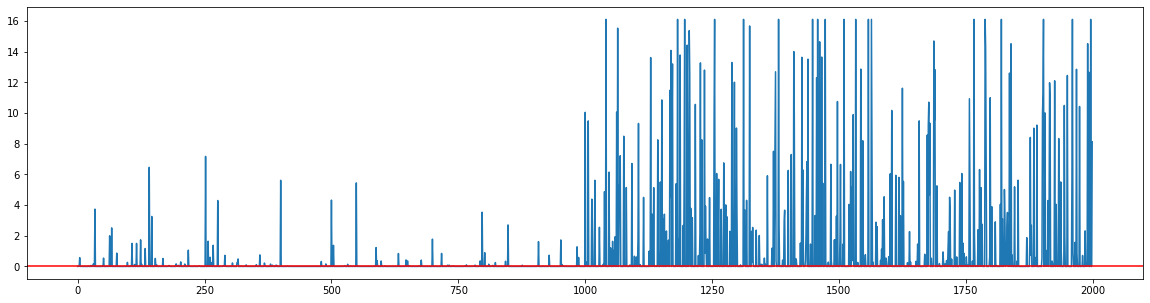

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(loss_test[1::5])
plt.axhline(y=loss_train_attacker.numpy(), c="red")

In [22]:
try:
    len(stats)
except:
    stats = []
stats.append({"val_acc":history.history['val_accuracy'][-1], "Adv_std":advantage, "unit_size":unit_size, "params":model.count_params()})
stats

[{'val_acc': 0.7741000056266785,
  'Adv_std': 22.14,
  'unit_size': 32,
  'params': 139482}]

## Federated split

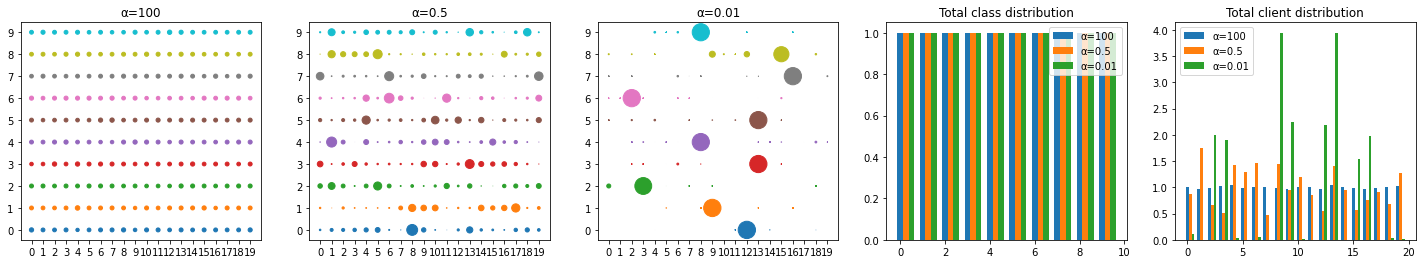

In [23]:
num_classes = 10
num_clients = 20

a_values = [100,0.5,0.01]
fig, axs = plt.subplots(1,len(a_values)+2, figsize=(25,4))
for i in range(len(a_values)):
    alpha = [a_values[i]] * num_clients
    s = np.random.default_rng().dirichlet(alpha, num_classes)
    for j, classes in enumerate(s):
        x = list(range(len(classes)))
        y = [j] * len(classes)
        axs[i].scatter(x, y, s=300*classes)
    axs[i].set_yticks(range(num_classes))
    axs[i].set_xticks(range(num_clients))
    axs[i].set_title(f'α={a_values[i]}')

    axs[-2].bar(np.arange(0,num_classes)+.25*i,np.sum(s.transpose(),0), label=f'α={a_values[i]}', width = 0.25)
    axs[-1].bar(np.arange(0,num_clients)+.25*i,np.sum(s,0)*(num_clients/num_classes), label=f'α={a_values[i]}', width = 0.25)
axs[-2].set_title(f'Total class distribution')    
axs[-2].legend()
axs[-1].set_title(f'Total client distribution')    
axs[-1].legend()
fig.show()

In [26]:
alpha = 0.5
alpha = [alpha] * num_clients

s = np.random.default_rng().dirichlet(alpha, num_classes)

In [55]:
X_train, Y_train = get_np_from_tfds(train_ds)

In [56]:
len(X_train[Y_train==0])

5000

In [124]:
X_split = None
Y_split = None

for cls in range(len(s)):
    X_cls = X_train[Y_train==cls]
    Y_cls = Y_train[Y_train==cls]
    cls_ex_num = len(X_cls)
    # print(sum(s[0]))
    # print(np.rint(s[0]*cls_ex_num))
    cls_split = np.rint(s[cls]*cls_ex_num)
    
    # if rounding error remove it from most populus one
    if sum(cls_split)>cls_ex_num:
        max_val = np.max(cls_split)
        max_idx = np.where(cls_split == max_val)[0][0]

        cls_split[max_idx] -= sum(cls_split)-cls_ex_num
    cls_split = cls_split.astype(int)
    
    X_cls_split = np.split(X_cls, np.cumsum(cls_split)[:-1])
    Y_cls_split = np.split(Y_cls, np.cumsum(cls_split)[:-1]) # these are just [cls]*cls_split
    
    if X_split is None:
        X_split = X_cls_split
        Y_split = Y_cls_split
    else:
        for i in range(len(X_cls_split)):

            X_split[i] = np.concatenate([X_split[i],X_cls_split[i]], axis=0)
            Y_split[i] = np.concatenate([Y_split[i],Y_cls_split[i]], axis=0)

In [100]:
for i in range(len(X_split)):
    print(len(X_split[i]),len(Y_split[i]))

50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000
50000 50000


In [103]:
for a in np.split(X_cls, np.cumsum(cls_split[:-1])):
    print(len(a))

986
116
11
0
1690
169
139
587
78
64
276
95
85
149
195
65
3
261
14
17


In [98]:
np.shape(X_split[0])

(200,)

In [112]:
np.split(X_cls, np.cumsum(cls_split)[:-1])[-1].shape

(17, 32, 32, 3)